In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

#import gensim
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
train = pd.read_csv("Training_Data.csv",encoding = "ISO-8859-1")

In [53]:
test_df = pd.read_csv("Test_Data14.csv",encoding = "ISO-8859-1")

In [54]:
test_df.head(4)

,unique_hash,text,drug
0,9e9a8166b84114aca147bf409f6f956635034c08,"256 (previously stable on natalizumab), with 5...",fingolimod
1,e747e6822c867571afe7b907b51f0f2ca67b0e1a,On fingolimod and have been since December 201...,fingolimod
2,50b6d851bcff4f35afe354937949e9948975adf7,Apparently it's shingles! :-/ I do have a few ...,humira
3,7f82ec2176ae6ab0b5d20b5ffc767ac829f384ae,If the Docetaxel doing once a week x3 weeks th...,tagrisso


In [3]:
train.head(5)

,unique_hash,text,drug,sentiment,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 697,Unnamed: 698,Unnamed: 699,Unnamed: 700,Unnamed: 701,Unnamed: 702,Unnamed: 703,Unnamed: 704,Unnamed: 705,Unnamed: 706
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,Autoimmune diseases tend to come in clusters. ...,gilenya,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,9eba8f80e7e20f3a2f48685530748fbfa95943e4,I can completely understand why youâd want t...,gilenya,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,fe809672251f6bd0d986e00380f48d047c7e7b76,Interesting that it only targets S1P-1/5 recep...,fingolimod,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,bd22104dfa9ec80db4099523e03fae7a52735eb6,"Very interesting, grand merci. Now I wonder wh...",ocrevus,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,b227688381f9b25e5b65109dd00f7f895e838249,"Hi everybody, My latest MRI results for Brain ...",gilenya,1,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
new = train[['unique_hash', 'text', 'drug','sentiment']].copy()

In [55]:
new = test_df[['unique_hash', 'text', 'drug','sentiment']].copy()

KeyError: "['sentiment'] not in index"

In [8]:
new.head(5)

,unique_hash,text,drug,sentiment
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,Autoimmune diseases tend to come in clusters. ...,gilenya,2
1,9eba8f80e7e20f3a2f48685530748fbfa95943e4,I can completely understand why youâd want t...,gilenya,2
2,fe809672251f6bd0d986e00380f48d047c7e7b76,Interesting that it only targets S1P-1/5 recep...,fingolimod,2
3,bd22104dfa9ec80db4099523e03fae7a52735eb6,"Very interesting, grand merci. Now I wonder wh...",ocrevus,2
4,b227688381f9b25e5b65109dd00f7f895e838249,"Hi everybody, My latest MRI results for Brain ...",gilenya,1


In [9]:
new.shape

(5315, 4)

In [10]:
new['sentiment'].value_counts()

2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       

In [14]:
# It mwans that unfortunately there are non numeric statements which need to be cleaned
# I have to remove the rows where it is non numeric 
# or 

In [11]:
a = new[new['sentiment']=="0"]

In [12]:
a1 = new[new['sentiment']=="1"]

In [13]:
a1.head(4)

,unique_hash,text,drug,sentiment
4,b227688381f9b25e5b65109dd00f7f895e838249,"Hi everybody, My latest MRI results for Brain ...",gilenya,1
8,8fd3d7ad80791c9343e5cf8a83bd1adf6577d516,Why do you think that FIngolimod was such a mi...,fingolimod,1
10,127a56fe52ebb4ac4bd7c44882b38c90b309b0d1,"I have no vision in one eye, unrelated to my e...",lucentis,1
20,174806d157718c27217a1dc6ee66f0388a58710b,BMC Ophthalmol. 2019 Jan 8;19(1):8. Intravitre...,dexamethasone,1


In [14]:
a2 = new[new['sentiment']=="2"]
a3 = new[new['sentiment']=="3"]

In [15]:
a2.head(4)

,unique_hash,text,drug,sentiment
0,2e180be4c9214c1f5ab51fd8cc32bc80c9f612e0,Autoimmune diseases tend to come in clusters. ...,gilenya,2
1,9eba8f80e7e20f3a2f48685530748fbfa95943e4,I can completely understand why youâd want t...,gilenya,2
2,fe809672251f6bd0d986e00380f48d047c7e7b76,Interesting that it only targets S1P-1/5 recep...,fingolimod,2
3,bd22104dfa9ec80db4099523e03fae7a52735eb6,"Very interesting, grand merci. Now I wonder wh...",ocrevus,2


In [16]:
a.shape,a1.shape,a2.shape

((612, 4), (837, 4), (3796, 4))

In [17]:
df_list = [a,a1,a2]

In [18]:
result = pd.concat(df_list, ignore_index = True)

In [19]:
result.head(5)

,unique_hash,text,drug,sentiment
0,be5a13376933a7f9bbf8e801c31691092f63260a,Reply posted for JessZidek. Hi Jess Sorry to r...,humira,0
1,e8f39b50683bb1b94689e8e462bdcd1aff331ee1,"Last Updated: January 01, 2017. Share | Comme...",ocrelizumab,0
2,c2df2a0e70805bb1a17305e2ac137aeae26d424a,Hi I was on rebif for about a year â rotate ...,fingolimod,0
3,603c2f1612eeabcaac016b6da0df4117b6a8ccd8,No problem. I know how hard and lonely this jo...,tecentriq,0
4,918b3d83f17c334962f30974f2ff1f16630eebf0,Conclusion: These real-life results suggest th...,dexamethasone implant,0


In [20]:
result.shape

(5245, 4)

In [21]:
df2 = result

In [22]:
df3 = df2.drop_duplicates()

In [23]:
df2.shape,df3.shape

((5245, 4), (5245, 4))

In [24]:
# The above thing confirms that there are no duplicates.

In [25]:
t1 = df2['text']

In [26]:
t1.head(4)

0    Reply posted for JessZidek. Hi Jess Sorry to r...
1    Last Updated: January 01, 2017.  Share | Comme...
2    Hi I was on rebif for about a year â rotate ...
3    No problem. I know how hard and lonely this jo...
Name: text, dtype: object

In [27]:
final = pd.DataFrame()

In [56]:
final1 = pd.DataFrame()

In [57]:
final1['Text'] = test_df['text']

In [28]:
final['Text'] = df2['text']

In [58]:
test_df.shape

(2924, 3)

In [59]:
# printing some random reviews
sent_0 = final1['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final1['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final1['Text'].values[1500]
print(sent_1500)
print("="*50)



256 (previously stable on natalizumab), with 55% switching to fingolimod
Hi Folks, Can anyone share the experiences with combo yervoy + Keytruda ? My mom is starting her first infusion next week. I am really scared and making false wishes that I can escape this but the truth is I have to walk this path with mom to her recovery. She is so healthy I am afraid this will put her down. Please share experiences.
@fxms , Iâm not sure what more Roche can do. Itâs now becoming a bit of a âbuggerâs muddleâ. If NICE had agreed a differential pricing for PPMS, how would that be managed? And, would there be a temptation to âcook the booksââ¦â¦. Surely no


In [29]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Reply posted for JessZidek. Hi Jess Sorry to read about the challenges you are having with your health. You mentioned a lot in your post. I just want to share some info on a few of the points. First, I know you said that you are scared of Humira. Humira and other biologics are very successful in reducing symptoms and inducing and maintain disease remission. To reduce your level of fear it can help to learn more about your treatment option. You can learn more about some of your treatment options. To learn more view our Understanding IBD Medication brochure at: http://www.crohnscolitisfoundation.org/assets/pdfs/understanding-ibd-meds-nov.pdf . If you would like to talk, contact the Help Center at 888-694-8872 or at info@crohnscolitisfoundation.org
I have my 2nd Entyvio infusion the day after tomorrow. Have had a tiny little setback -- 3 days after my 1st infusion, I developed a bladder infection, so was put on cipro for a week, which I just finished yesterday. Have been having a little b

Today was awesome. The Great Scott solved all of my problems. We have a great treatment plan devised that is sure to bring me to new levels of health and wellness. I went in hopeless and I re-emerged energized! Full of hope. MS does NOT have me! Okâ¦Iâm just fucking with you. Thatâs not how today went at all. Today wasâ¦a lot. Iâm going to try and break it down in such a way that wonât result in The Great Scott getting hate mail. I must stress up front, that I trust this man. I know he wants whatâs best for me. Iâm in his category of âdifficultâ cases and he seems dedicated to working with me to get me to some kind of stability. While I do not doubt his intentions for even a single second, nor do I doubt his knowledge or skill or experience, I do wish heâd work on his words a bit. His non-medical jargon words are not terribly helpful. His words areâ¦just off. The thing is, if he did that, if he got better with his words then these posts wouldnât be so entertainin

In [60]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
print(sent_0)

256 (previously stable on natalizumab), with 55% switching to fingolimod


In [30]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Reply posted for JessZidek. Hi Jess Sorry to read about the challenges you are having with your health. You mentioned a lot in your post. I just want to share some info on a few of the points. First, I know you said that you are scared of Humira. Humira and other biologics are very successful in reducing symptoms and inducing and maintain disease remission. To reduce your level of fear it can help to learn more about your treatment option. You can learn more about some of your treatment options. To learn more view our Understanding IBD Medication brochure at:  . If you would like to talk, contact the Help Center at 888-694-8872 or at info@crohnscolitisfoundation.org


In [61]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

#soup = BeautifulSoup(sent_4900, 'lxml')
#text = soup.get_text()
#print(text)

256 (previously stable on natalizumab), with 55% switching to fingolimod
Hi Folks, Can anyone share the experiences with combo yervoy + Keytruda ? My mom is starting her first infusion next week. I am really scared and making false wishes that I can escape this but the truth is I have to walk this path with mom to her recovery. She is so healthy I am afraid this will put her down. Please share experiences.
@fxms , Iâm not sure what more Roche can do. Itâs now becoming a bit of a âbuggerâs muddleâ. If NICE had agreed a differential pricing for PPMS, how would that be managed? And, would there be a temptation to âcook the booksââ¦â¦. Surely no


In [31]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

Reply posted for JessZidek. Hi Jess Sorry to read about the challenges you are having with your health. You mentioned a lot in your post. I just want to share some info on a few of the points. First, I know you said that you are scared of Humira. Humira and other biologics are very successful in reducing symptoms and inducing and maintain disease remission. To reduce your level of fear it can help to learn more about your treatment option. You can learn more about some of your treatment options. To learn more view our Understanding IBD Medication brochure at:  . If you would like to talk, contact the Help Center at 888-694-8872 or at info@crohnscolitisfoundation.org
I have my 2nd Entyvio infusion the day after tomorrow. Have had a tiny little setback -- 3 days after my 1st infusion, I developed a bladder infection, so was put on cipro for a week, which I just finished yesterday. Have been having a little bit of stomach pains -- nothing severe, but enough to let me know that this flare 

Today was awesome. The Great Scott solved all of my problems. We have a great treatment plan devised that is sure to bring me to new levels of health and wellness. I went in hopeless and I re-emerged energized! Full of hope. MS does NOT have me! Okâ¦Iâm just fucking with you. Thatâs not how today went at all. Today wasâ¦a lot. Iâm going to try and break it down in such a way that wonât result in The Great Scott getting hate mail. I must stress up front, that I trust this man. I know he wants whatâs best for me. Iâm in his category of âdifficultâ cases and he seems dedicated to working with me to get me to some kind of stability. While I do not doubt his intentions for even a single second, nor do I doubt his knowledge or skill or experience, I do wish heâd work on his words a bit. His non-medical jargon words are not terribly helpful. His words areâ¦just off. The thing is, if he did that, if he got better with his words then these posts wouldnât be so entertainin

In [33]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [62]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

@fxms , Iâm not sure what more Roche can do. Itâs now becoming a bit of a âbuggerâs muddleâ. If NICE had agreed a differential pricing for PPMS, how would that be managed? And, would there be a temptation to âcook the booksââ¦â¦. Surely no


In [34]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Thank you, Merry. You are a world of knowledge and support. I actually joined a Chemo Support group on FB and everyone shares knowledge and experience. I did get a wig a couple of weeks ago and ordered a couple of the Chemo caps, which look horrible on me! Guess I can wear them around the house. I need more poof. Have read it is better to buzz your head rather then shave it. Yes, this is very hard as I am one that curls and styles my hair every day. Now, I have not washed it for a week. I guess, since I have not been given many options for treatment, this almost seems futile but I do not want to die any time soon. I would talk to Wakekee before I make any decisions. Was thinking of maybe going to Scripps but, again, would be difficult and I hate to be far from home. Will see what he says this morning.  Jump to this post Saw my dictir this morning. My Neutrophols are only .8! He us skipping Chemo this week, will recheck blood work on Tuesday, Chemo next week for 3 days the 5 days of Gra

In [63]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

(previously stable on natalizumab), with  switching to fingolimod


In [35]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Reply posted for JessZidek. Hi Jess Sorry to read about the challenges you are having with your health. You mentioned a lot in your post. I just want to share some info on a few of the points. First, I know you said that you are scared of Humira. Humira and other biologics are very successful in reducing symptoms and inducing and maintain disease remission. To reduce your level of fear it can help to learn more about your treatment option. You can learn more about some of your treatment options. To learn more view our Understanding IBD Medication brochure at:  . If you would like to talk, contact the Help Center at  or at info@crohnscolitisfoundation.org


In [64]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

 fxms I m not sure what more Roche can do It s now becoming a bit of a bugger s muddle If NICE had agreed a differential pricing for PPMS how would that be managed And would there be a temptation to cook the books Surely no


In [36]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Thank you Merry You are a world of knowledge and support I actually joined a Chemo Support group on FB and everyone shares knowledge and experience I did get a wig a couple of weeks ago and ordered a couple of the Chemo caps which look horrible on me Guess I can wear them around the house I need more poof Have read it is better to buzz your head rather then shave it Yes this is very hard as I am one that curls and styles my hair every day Now I have not washed it for a week I guess since I have not been given many options for treatment this almost seems futile but I do not want to die any time soon I would talk to Wakekee before I make any decisions Was thinking of maybe going to Scripps but again would be difficult and I hate to be far from home Will see what he says this morning Jump to this post Saw my dictir this morning My Neutrophols are only 8 He us skipping Chemo this week will recheck blood work on Tuesday Chemo next week for 3 days the 5 days of Granix injections Going to try

In [37]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [65]:
from tqdm import tqdm
preprocessed_reviews1 = []
# tqdm is for printing the status bar
for sentance in tqdm(test_df['text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews1.append(sentance.strip())

100%|█████████████████████████████████████████████████████████████████████████████| 2924/2924 [00:04<00:00, 668.64it/s]


In [38]:
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(df2['text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|█████████████████████████████████████████████████████████████████████████████| 5245/5245 [00:06<00:00, 775.77it/s]


In [56]:
# Now Preprocessed Reviews is the cleaned text data  - Train Data

In [44]:
final.head(5)

,Text,Cleaned Text,sentiment
0,Reply posted for JessZidek. Hi Jess Sorry to r...,reply posted jesszidek hi jess sorry read chal...,0
1,"Last Updated: January 01, 2017. Share | Comme...",last updated january share comments tell frien...,0
2,Hi I was on rebif for about a year â rotate ...,hi rebif year rotate injection sites remember ...,0
3,No problem. I know how hard and lonely this jo...,no problem know hard lonely journey happy help...,0
4,Conclusion: These real-life results suggest th...,conclusion real life results suggest intravitr...,0


In [40]:
final['Cleaned Text'] = preprocessed_reviews

In [42]:
df2.head(4)

,unique_hash,text,drug,sentiment
0,be5a13376933a7f9bbf8e801c31691092f63260a,Reply posted for JessZidek. Hi Jess Sorry to r...,humira,0
1,e8f39b50683bb1b94689e8e462bdcd1aff331ee1,"Last Updated: January 01, 2017. Share | Comme...",ocrelizumab,0
2,c2df2a0e70805bb1a17305e2ac137aeae26d424a,Hi I was on rebif for about a year â rotate ...,fingolimod,0
3,603c2f1612eeabcaac016b6da0df4117b6a8ccd8,No problem. I know how hard and lonely this jo...,tecentriq,0


In [43]:
final['sentiment'] = df2['sentiment']

In [45]:
new123 = pd.DataFrame()

In [46]:
new123['Cleaned Text'] = final['Cleaned Text']

In [47]:
new123.head(5)

,Cleaned Text
0,reply posted jesszidek hi jess sorry read chal...
1,last updated january share comments tell frien...
2,hi rebif year rotate injection sites remember ...
3,no problem know hard lonely journey happy help...
4,conclusion real life results suggest intravitr...


In [52]:
new123['length'] = k1

In [50]:
k1 = []

In [51]:
for i in range(0,len(preprocessed_reviews)):
    k1.append(len(preprocessed_reviews[i]))

In [68]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

In [69]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(new123,final['sentiment'].values,test_size=0.3,shuffle=False)

In [70]:
y_train1.shape

(3671,)

In [71]:
y_test1.shape

(1574,)

In [72]:
X_train1.shape

(3671, 2)

In [73]:
X_test1.shape

(1574, 2)

In [74]:
len(X_train1.values)

3671

In [75]:
X_train1.head(5)

,Cleaned Text,length
0,reply posted jesszidek hi jess sorry read chal...,401
1,last updated january share comments tell frien...,14476
2,hi rebif year rotate injection sites remember ...,162
3,no problem know hard lonely journey happy help...,785
4,conclusion real life results suggest intravitr...,134


In [76]:
X_test1.head(5)

,Cleaned Text,length
3671,beth second ocrevus infusion yesterday nurses ...,326
3672,diagnosed uc years ago total colectomy surgery...,624
3673,rilonacept used treat symptoms rare genetic co...,5279
3674,max dose lialda tablets day started flaring in...,1100
3675,grandma think may find tad daunting quite hone...,170


In [77]:
X_trainbow = pd.DataFrame()
X_trainbow['Cleaned Text'] = X_train1['Cleaned Text']
X_trainbow['Length'] = X_train1['length']

In [78]:
X_testbow = pd.DataFrame()
X_testbow['Cleaned Text'] = X_test1['Cleaned Text']
X_testbow['Length'] = X_test1['length']

# IMPLEMENTING BAG OF WORDS  

In [79]:
count_vect = CountVectorizer() 
a1 = count_vect.fit_transform(X_trainbow['Cleaned Text'].values)
b1 = count_vect.transform(X_testbow['Cleaned Text'])

In [80]:
print("the type of count vectorizer :",type(a1))
print("the shape of out text BOW vectorizer : ",a1.get_shape())
print("the number of unique words :", a1.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer :  (3671, 27066)
the number of unique words : 27066


In [81]:
from sklearn.model_selection import train_test_split
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import *
from sklearn.linear_model import LogisticRegression

In [82]:
a1 = preprocessing.normalize(a1)
b1 = preprocessing.normalize(b1)

In [83]:
from scipy import sparse
from scipy.sparse import csr_matrix

In [84]:
a2 = sparse.csr_matrix(X_train1['length'].values)
a2 = preprocessing.normalize(a2)
a3 = sparse.hstack([a1, a2.T])

In [85]:
b2 = sparse.csr_matrix(X_test1['length'].values)
b2 = preprocessing.normalize(b2)
b3 = sparse.hstack([b1, b2.T])                       

# USING F1 MICRO 

In [86]:
#refer: http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer
#tuned_parameters = [{'C': [10**2, 10**4,10**5]}]
tuned_parameters = [{'C': [10**-5,10**-4, 10**-2, 10**0, 10**2, 10**4,10**5]}]
# AS C INCREASES IT SHOULD OVERFIT. HERE C IS NOTHING BUT 1/LAMDA. LAMDA IS THE HYPER PARAMETER.
#Using GridSearchCV
model1 = GridSearchCV(LogisticRegression(solver = 'lbfgs',multi_class='multinomial', max_iter = 1500), tuned_parameters, scoring = 'f1_micro', cv=5, return_train_score= True)
model1.fit(a3, y_train1)
print(model1.best_estimator_)

KeyboardInterrupt: 

In [211]:
print(model1.score(b3, y_test1))

0.9161372299872935


In [213]:
tuned_parameters = [{'C': [10**-5,10**-4, 10**-2, 10**0, 10**2, 10**4,10**5]}]
# AS C INCREASES IT SHOULD OVERFIT. HERE C IS NOTHING BUT 1/LAMDA. LAMDA IS THE HYPER PARAMETER.
#Using GridSearchCV
model11 = GridSearchCV(LogisticRegression(solver = 'lbfgs',multi_class='multinomial', max_iter = 1500), tuned_parameters, scoring = 'f1_micro', cv=5, return_train_score= True)
model11.fit(a1, y_train1)
print(model11.best_estimator_)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [214]:
print(model11.score(b1, y_test1))

0.9148665819567979


# USING F1 MACRO - BOW

In [181]:
#tuned_parameters = [{'C': [10**2, 10**4,10**5]}]
tuned_parameters = [{'C': [10**-5,10**-4, 10**-2, 10**0, 10**2, 10**4,10**5]}]
# AS C INCREASES IT SHOULD OVERFIT. HERE C IS NOTHING BUT 1/LAMDA. LAMDA IS THE HYPER PARAMETER.
#Using GridSearchCV
model2 = GridSearchCV(LogisticRegression(solver = 'lbfgs',multi_class='multinomial', max_iter = 1500), tuned_parameters, scoring = 'f1_macro', cv=5, return_train_score= True)
model2.fit(a3, y_train1)
print(model2.best_estimator_)
print(model2.score(b3, y_test1))

C:\Users\VishnuVardhan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\VishnuVardhan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\VishnuVardhan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\VishnuVardhan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\VishnuVardhan\Anaco

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


C:\Users\VishnuVardhan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.2849521037953195


In [87]:
tf_idf_vect = TfidfVectorizer()
c1 = tf_idf_vect.fit_transform(X_trainbow['Cleaned Text'].values)
d1 = tf_idf_vect.transform(X_testbow['Cleaned Text'])
print("the type of count vectorizer :",type(c1))
print("the shape of out text TFIDF vectorizer : ",c1.get_shape())
print("the number of unique words :", c1.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (3671, 27066)
the number of unique words : 27066


In [88]:
c1 = preprocessing.normalize(c1)
c2 = sparse.csr_matrix(X_train1['length'].values)
c2 = preprocessing.normalize(c2)
c3 = sparse.hstack([c1, c2.T])

In [89]:
d1 = preprocessing.normalize(d1)
d2 = sparse.csr_matrix(X_test1['length'].values)
d2 = preprocessing.normalize(d2)
d3 = sparse.hstack([d1, d2.T])

# TFIDF - F1 MICRO 

In [209]:
tuned_parameters = [{'C': [10**-5,10**-4, 10**-2, 10**0, 10**2, 10**4,10**5]}]
# AS C INCREASES IT SHOULD OVERFIT. HERE C IS NOTHING BUT 1/LAMDA. LAMDA IS THE HYPER PARAMETER.
#Using GridSearchCV
model3 = GridSearchCV(LogisticRegression(solver = 'lbfgs',multi_class='multinomial', max_iter = 1500), tuned_parameters, scoring = 'f1_micro', cv=5, return_train_score= True)
model3.fit(c3, y_train1)
print(model3.best_estimator_)
print(model3.score(d3, y_test1))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
0.9275730622617535


# TFIDF - F1 MACRO 

In [208]:
tuned_parameters = [{'C': [10**-5,10**-4, 10**-2, 10**0, 10**2, 10**4,10**5]}]
# AS C INCREASES IT SHOULD OVERFIT. HERE C IS NOTHING BUT 1/LAMDA. LAMDA IS THE HYPER PARAMETER.
#Using GridSearchCV
model4 = GridSearchCV(LogisticRegression(solver = 'lbfgs',multi_class='multinomial', max_iter = 1500), tuned_parameters, scoring = 'f1_macro', cv=5, return_train_score= True)
model4.fit(c3, y_train1)
print(model4.best_estimator_)
print(model4.score(d3, y_test1))

C:\Users\VishnuVardhan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\VishnuVardhan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\VishnuVardhan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\VishnuVardhan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\VishnuVardhan\Anaco

LogisticRegression(C=10000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


C:\Users\VishnuVardhan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.28467419002548233


# AVGW2V 

In [187]:
i=0
list_of_sentance=[]
for sentance in (X_trainbow['Cleaned Text'].values):
    list_of_sentance.append(sentance.split())

In [188]:
#WORD TO VECTOR

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")


w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

[('hear', 0.9803595542907715), ('sorry', 0.9768660068511963), ('hope', 0.9612845778465271), ('thoughts', 0.9600058794021606), ('glad', 0.9597508907318115), ('luck', 0.9572322368621826), ('everyone', 0.9561948776245117), ('happy', 0.9555653929710388), ('love', 0.9507182240486145), ('thank', 0.9481939673423767)]
[('awful', 0.984891951084137), ('horrible', 0.974980354309082), ('weird', 0.9741758108139038), ('relief', 0.9739112854003906), ('fun', 0.9711474180221558), ('helped', 0.9701564311981201), ('lady', 0.9699545502662659), ('noticed', 0.9691743850708008), ('gotten', 0.9666872024536133), ('hell', 0.9662218689918518)]
number of words that occured minimum 5 times  9013
sample words  ['reply', 'posted', 'hi', 'sorry', 'read', 'challenges', 'health', 'mentioned', 'lot', 'post', 'want', 'share', 'info', 'points', 'first', 'know', 'said', 'scared', 'humira', 'biologics', 'successful', 'reducing', 'symptoms', 'inducing', 'maintain', 'disease', 'remission', 'reduce', 'level', 'fear', 'help', '

In [189]:
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 3671/3671 [00:17<00:00, 208.38it/s]


3671
50


In [190]:
i=0
list_of_sentance1=[]
for sentance in (X_test1['Cleaned Text'].values):
    list_of_sentance1.append(sentance.split())

In [191]:
is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model1=Word2Vec(list_of_sentance1,min_count=5,size=50, workers=4)
    print(w2v_model1.wv.most_similar('great'))
    print('='*50)
    print(w2v_model1.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model1=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model1.wv.most_similar('great'))
        print(w2v_model1.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")


w2v_words1 = list(w2v_model1.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words1))
print("sample words ", w2v_words1[0:50])

[('pretty', 0.9978894591331482), ('mind', 0.9973368048667908), ('little', 0.9971143007278442), ('wanted', 0.9968970417976379), ('bit', 0.9967705011367798), ('felt', 0.99553382396698), ('hard', 0.9955053329467773), ('trying', 0.9954373836517334), ('stay', 0.9950129985809326), ('definitely', 0.9945928454399109)]
[('everything', 0.998406171798706), ('ok', 0.9979478120803833), ('nothing', 0.9974957704544067), ('morning', 0.9973071217536926), ('happy', 0.9972931146621704), ('woke', 0.9970003366470337), ('definitely', 0.996965229511261), ('appointments', 0.996893584728241), ('anymore', 0.996607780456543), ('goes', 0.9963794946670532)]
number of words that occured minimum 5 times  6336
sample words  ['beth', 'second', 'ocrevus', 'infusion', 'yesterday', 'nurses', 'center', 'asking', 'symptoms', 'prior', 'coming', 'apparently', 'lot', 'patients', 'saying', 'notice', 'increase', 'fatigue', 'goes', 'month', 'two', 'scheduled', 'like', 'many', 'past', 'appearing', 'frequent', 'rate', 'months', 'a

In [192]:
sent_vectors1 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance1): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words1:
            vec = w2v_model1.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors1.append(sent_vec)
print(len(sent_vectors1))
print(len(sent_vectors1[0]))

100%|█████████████████████████████████████████████████████████████████████████████| 1574/1574 [00:06<00:00, 227.25it/s]


1574
50


In [193]:
e3 = sent_vectors
f3 = sent_vectors1

In [195]:
e3 = preprocessing.normalize(e3)
e4 = sparse.csr_matrix(X_train1['length'].values)
e4 = preprocessing.normalize(e4)
e5 = sparse.hstack([e3, e4.T])

In [196]:
f3 = preprocessing.normalize(f3)
f4 = sparse.csr_matrix(X_test1['length'].values)
f4 = preprocessing.normalize(f4)
f5 = sparse.hstack([f3, f4.T])

In [198]:
tuned_parameters = [{'C': [10**-5,10**-4, 10**-2, 10**0, 10**2, 10**4,10**5]}]
# AS C INCREASES IT SHOULD OVERFIT. HERE C IS NOTHING BUT 1/LAMDA. LAMDA IS THE HYPER PARAMETER.
#Using GridSearchCV
model6 = GridSearchCV(LogisticRegression(solver = 'lbfgs',multi_class='multinomial', max_iter = 1500), tuned_parameters, scoring = 'f1_macro', cv=5, return_train_score= True)
model6.fit(e5, y_train1)
print(model6.best_estimator_)
print(model6.score(f5, y_test1))

C:\Users\VishnuVardhan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\VishnuVardhan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\VishnuVardhan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\VishnuVardhan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\VishnuVardhan\Anaco

C:\Users\VishnuVardhan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\VishnuVardhan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\VishnuVardhan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\VishnuVardhan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\VishnuVardhan\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of it

LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


C:\Users\VishnuVardhan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.0008460236886632825


In [199]:
# w2v is not working properly ...
# let's move to avg w2v tfidf

# TFIDF - AVG W2V

In [200]:
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_trainbow['Cleaned Text'].values)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [201]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 3671/3671 [02:02<00:00, 40.03it/s]


In [202]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance1): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words1 and word in tfidf_feat:
            vec = w2v_model1.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors1.append(sent_vec)
    row += 1

100%|██████████████████████████████████████████████████████████████████████████████| 1574/1574 [00:53<00:00, 29.35it/s]


In [203]:
g3 = tfidf_sent_vectors
h3 = tfidf_sent_vectors1

In [204]:
g3 = preprocessing.normalize(g3)
g4 = sparse.csr_matrix(X_train1['length'].values)
g4 = preprocessing.normalize(g4)
g5 = sparse.hstack([g3, g4.T])

In [206]:
h3 = preprocessing.normalize(h3)
h4 = sparse.csr_matrix(X_test1['length'].values)
h4 = preprocessing.normalize(h4)
h5 = sparse.hstack([h3, h4.T])

In [207]:
tuned_parameters = [{'C': [10**-5,10**-4, 10**-2, 10**0, 10**2, 10**4,10**5]}]
# AS C INCREASES IT SHOULD OVERFIT. HERE C IS NOTHING BUT 1/LAMDA. LAMDA IS THE HYPER PARAMETER.
#Using GridSearchCV
model6 = GridSearchCV(LogisticRegression(solver = 'lbfgs',multi_class='multinomial', max_iter = 1500), tuned_parameters, scoring = 'f1_macro', cv=5, return_train_score= True)
model6.fit(g5, y_train1)
print(model6.best_estimator_)
print(model6.score(h5, y_test1))

C:\Users\VishnuVardhan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\VishnuVardhan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\VishnuVardhan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\VishnuVardhan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\VishnuVardhan\Anaco

LogisticRegression(C=100000, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


C:\Users\VishnuVardhan\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


0.016522098306484923


# Observations:
1) Only Bow and tf-idf works reasonably better.

In [215]:
# c3 and d3 should be used. 

In [216]:
# Running the Model with the best hyper parameter c = 

In [217]:
# Before that I am converting the text data 

In [66]:
final1['Cleaned Text'] = preprocessed_reviews1

In [67]:
final1.head(5)

,Text,Cleaned Text
0,"256 (previously stable on natalizumab), with 5...",previously stable natalizumab switching fingol...
1,On fingolimod and have been since December 201...,fingolimod since december way describe better ...
2,Apparently it's shingles! :-/ I do have a few ...,apparently shingles red spots left breast appe...
3,If the Docetaxel doing once a week x3 weeks th...,docetaxel week weeks week claim less harsh eff...
4,"CC, Stelara worked in a matter of days for me....",cc stelara worked matter days gi willing jump ...


# FIRST - SUBMISSION - TFIDF - L2 PENALTY WITH OUT FEATURE ENGINEERING 

In [90]:
tf_idf_vect = TfidfVectorizer()
c1 = tf_idf_vect.fit_transform(X_trainbow['Cleaned Text'].values)
d134 = tf_idf_vect.transform(final1['Cleaned Text'])
print("the type of count vectorizer :",type(c1))
print("the shape of out text TFIDF vectorizer : ",c1.get_shape())
print("the number of unique words :", c1.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (3671, 27066)
the number of unique words : 27066


In [91]:
c1 = preprocessing.normalize(c1)
d134 = preprocessing.normalize(d134)

In [92]:
om_tfidfl1 = LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='multinomial', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [93]:
om_tfidfl1.fit(c1, y_train1)

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='multinomial', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)

In [94]:
ompredictions_tfidfl1  = om_tfidfl1.predict(d134)

In [95]:
df_sub3 = pd.DataFrame()
df_sub3['unique_hash'] = test_df['unique_hash']
df_sub3['sentiment'] = ompredictions_tfidfl1

In [96]:
#df_sub['sentiment'].value_counts()

NameError: name 'df_sub' is not defined

In [292]:
df_sub2['sentiment'].value_counts()

2    1750
1     633
0     541
Name: sentiment, dtype: int64

In [97]:
df_sub3['sentiment'].value_counts()

2    1457
0     771
1     696
Name: sentiment, dtype: int64

In [294]:
df_sub3.to_csv('my_submission3.csv', index=False)

In [254]:
om_tfidf = LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [295]:
om_tfidf1 = LogisticRegression(C=1, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [255]:
om_tfidf.fit(c1, y_train1)

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [297]:
om_tfidf1.fit(c1, y_train1)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [256]:
ompredictions_tfidf  = om_tfidf.predict(d134)

In [298]:
ompredictions_tfidf1  = om_tfidf1.predict(d134)

In [257]:
ompredictions_tfidf

array(['2', '1', '2', ..., '1', '2', '2'], dtype=object)

In [299]:
df_sub4 = pd.DataFrame()
df_sub4['unique_hash'] = test_df['unique_hash']
df_sub4['sentiment'] = ompredictions_tfidf1

In [300]:
df_sub4.to_csv('my_submission4.csv', index=False)

In [258]:
test_df.head(5)

,unique_hash,text,drug
0,9e9a8166b84114aca147bf409f6f956635034c08,"256 (previously stable on natalizumab), with 5...",fingolimod
1,e747e6822c867571afe7b907b51f0f2ca67b0e1a,On fingolimod and have been since December 201...,fingolimod
2,50b6d851bcff4f35afe354937949e9948975adf7,Apparently it's shingles! :-/ I do have a few ...,humira
3,7f82ec2176ae6ab0b5d20b5ffc767ac829f384ae,If the Docetaxel doing once a week x3 weeks th...,tagrisso
4,8b37d169dee5bdae27060949242fb54feb6a7f7f,"CC, Stelara worked in a matter of days for me....",stelara


In [259]:
df_sub = pd.DataFrame()

In [260]:
df_sub['unique_hash'] = test_df['unique_hash']

In [261]:
df_sub['sentiment'] = ompredictions_tfidf

In [262]:
df_sub.shape

(2924, 2)

In [263]:
df_sub.head(4)

,unique_hash,sentiment
0,9e9a8166b84114aca147bf409f6f956635034c08,2
1,e747e6822c867571afe7b907b51f0f2ca67b0e1a,1
2,50b6d851bcff4f35afe354937949e9948975adf7,2
3,7f82ec2176ae6ab0b5d20b5ffc767ac829f384ae,2


In [264]:
df_sub['sentiment'].value_counts()

2    1753
1     632
0     539
Name: sentiment, dtype: int64

In [265]:
df_sub.to_csv('my_submission1.csv', index=False)

# l2 penalty with feature engineering 

In [266]:
tf_idf_vect = TfidfVectorizer()
c1 = tf_idf_vect.fit_transform(X_trainbow['Cleaned Text'].values)
d134 = tf_idf_vect.transform(final1['Cleaned Text'])
print("the type of count vectorizer :",type(c1))
print("the shape of out text TFIDF vectorizer : ",c1.get_shape())
print("the number of unique words :", c1.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (3671, 27066)
the number of unique words : 27066


In [270]:
om_tfidf.fit(c3, y_train1)

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [118]:
k3 = []

In [119]:
for i in range(0,len(preprocessed_reviews1)):
    k3.append(len(preprocessed_reviews1[i]))

In [121]:
final1.head(4)

,Text,Cleaned Text,length
0,"256 (previously stable on natalizumab), with 5...",previously stable natalizumab switching fingol...,50
1,On fingolimod and have been since December 201...,fingolimod since december way describe better ...,78
2,Apparently it's shingles! :-/ I do have a few ...,apparently shingles red spots left breast appe...,647
3,If the Docetaxel doing once a week x3 weeks th...,docetaxel week weeks week claim less harsh eff...,528


In [272]:
final1.shape

(2924, 2)

In [120]:
final1['length'] = k3

In [274]:
final1.head(3)

,Text,Cleaned Text,length
0,"256 (previously stable on natalizumab), with 5...",previously stable natalizumab switching fingol...,50
1,On fingolimod and have been since December 201...,fingolimod since december way describe better ...,78
2,Apparently it's shingles! :-/ I do have a few ...,apparently shingles red spots left breast appe...,647


In [269]:
d134 = preprocessing.normalize(d134)

In [275]:
d135 = sparse.csr_matrix(final1['length'].values)
d135 = preprocessing.normalize(d135)
d136 = sparse.hstack([d134, d135.T])

In [277]:
ompredictions_tfidf  = om_tfidf.predict(d136)

In [278]:
df_sub2 = pd.DataFrame()
df_sub2['unique_hash'] = test_df['unique_hash']
df_sub2['sentiment'] = ompredictions_tfidf

In [279]:
df_sub2.to_csv('my_submission2.csv', index=False)

# with out normalising and with out feature engineering TFIDF 

In [301]:
tf_idf_vect = TfidfVectorizer()
c1 = tf_idf_vect.fit_transform(X_trainbow['Cleaned Text'].values)
d134 = tf_idf_vect.transform(final1['Cleaned Text'])
print("the type of count vectorizer :",type(c1))
print("the shape of out text TFIDF vectorizer : ",c1.get_shape())
print("the number of unique words :", c1.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (3671, 27066)
the number of unique words : 27066


In [305]:
d134 = preprocessing.normalize(d134)
d135 = sparse.csr_matrix(final1['length'].values)
d135 = preprocessing.normalize(d135)
d136 = sparse.hstack([d134, d135.T])

In [306]:
om_tfidf = LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter= 2000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [307]:
om_tfidf.fit(c3, y_train1)

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=2000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [308]:
ompredictions_tfidf  = om_tfidf.predict(d136)

In [309]:
df_sub6 = pd.DataFrame()
df_sub6['unique_hash'] = test_df['unique_hash']
df_sub6['sentiment'] = ompredictions_tfidf
df_sub6.to_csv('my_submission6.csv', index=False)

# BOW 

In [108]:
count_vect = CountVectorizer() 
a1 = count_vect.fit_transform(X_trainbow['Cleaned Text'].values)
b134 = count_vect.transform(final1['Cleaned Text'])

In [311]:
#d134 = tf_idf_vect.transform(final1['Cleaned Text'])
print("the type of count vectorizer :",type(a1))
print("the shape of out text TFIDF vectorizer : ",a1.get_shape())
print("the number of unique words :", a1.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (3671, 27066)
the number of unique words : 27066


In [313]:
om_bow = LogisticRegression(C=1, class_weight= 'balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [109]:
a1 = preprocessing.normalize(a1)
b134 = preprocessing.normalize(b134)

In [316]:
om_bow.fit(a1, y_train1)

LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [317]:
ompredictions_bow  = om_bow.predict(b134)

In [318]:
df_sub7 = pd.DataFrame()
df_sub7['unique_hash'] = test_df['unique_hash']
df_sub7['sentiment'] = ompredictions_bow
df_sub7.to_csv('my_submission7.csv', index=False)

# NAIVE BAYES 

In [98]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix,f1_score,precision_score,recall_score
from sklearn.naive_bayes import MultinomialNB

In [99]:
from sklearn.model_selection import GridSearchCV

In [111]:
nb=MultinomialNB()
parameters={'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}
model6=GridSearchCV(nb,parameters,cv=25, scoring = 'f1_micro', return_train_score= True)
model6.fit(a1, y_train1)
print(model6.best_estimator_)
print(model6.score(b1, y_test1))
#model6.fit(a1, y_train1)
#print(model6.best_estimator_)
#print(model6.score(b1, y_test1))

MultinomialNB(alpha=0.0001, class_prior=None, fit_prior=True)
0.8780177890724269


In [136]:
import seaborn as sns

C:\Users\VishnuVardhan\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


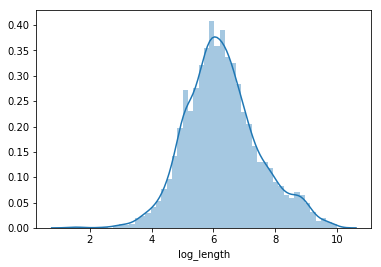

In [151]:
sns.distplot(final['log_length'])

In [140]:
final1.head(4)

,Text,Cleaned Text,length,log_length
0,"256 (previously stable on natalizumab), with 5...",previously stable natalizumab switching fingol...,50,3.912023
1,On fingolimod and have been since December 201...,fingolimod since december way describe better ...,78,4.356709
2,Apparently it's shingles! :-/ I do have a few ...,apparently shingles red spots left breast appe...,647,6.472346
3,If the Docetaxel doing once a week x3 weeks th...,docetaxel week weeks week claim less harsh eff...,528,6.269096


In [150]:
final.head(3)

,Text,Cleaned Text,sentiment,length,log_length
0,Reply posted for JessZidek. Hi Jess Sorry to r...,reply posted jesszidek hi jess sorry read chal...,0,401,5.993961
1,"Last Updated: January 01, 2017. Share | Comme...",last updated january share comments tell frien...,0,14476,9.580247
2,Hi I was on rebif for about a year â rotate ...,hi rebif year rotate injection sites remember ...,0,162,5.087596


In [162]:
X_train1.shape

(3671, 3)

In [161]:
X_train1.head(3)

,Cleaned Text,length,log_length
0,reply posted jesszidek hi jess sorry read chal...,401,5.993961
1,last updated january share comments tell frien...,14476,9.580247
2,hi rebif year rotate injection sites remember ...,162,5.087596


In [160]:
X_train1['log_length'] = np.log(X_train1['length'])

In [146]:
final['length'] = new123['length']

In [149]:
final['log_length'] = np.log(final['length'])

In [144]:
new123.head(3)

,Cleaned Text,length
0,reply posted jesszidek hi jess sorry read chal...,401
1,last updated january share comments tell frien...,14476
2,hi rebif year rotate injection sites remember ...,162


In [145]:
final.shape, new123.shape

((5245, 3), (5245, 2))

In [139]:
final1['log_length'] = np.log(final1['length'])

In [110]:
om_bow = MultinomialNB(alpha = 0.0001)
# fitting the model and predicting the responses
om_bow.fit(a1, y_train1)
ompredictions_bow  = om_bow.predict(b134)

In [112]:
df_sub8 = pd.DataFrame()
df_sub8['unique_hash'] = test_df['unique_hash']
df_sub8['sentiment'] = ompredictions_bow
df_sub8.to_csv('my_submission8.csv', index=False)

In [163]:
tf_idf_vect = TfidfVectorizer()
c1 = tf_idf_vect.fit_transform(X_trainbow['Cleaned Text'].values)
d1 = tf_idf_vect.transform(final1['Cleaned Text'])
print("the type of count vectorizer :",type(c1))
print("the shape of out text TFIDF vectorizer : ",c1.get_shape())
print("the number of unique words :", c1.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (3671, 27066)
the number of unique words : 27066


In [157]:
len(final['length']),len(X_train1['length'])

(5245, 3671)

In [164]:
c1 = preprocessing.normalize(c1)
c4 = sparse.csr_matrix(X_train1['log_length'].values)
#c2 = preprocessing.normalize(c2)
c5 = sparse.hstack([c1, c4.T])

In [131]:
final1.head(3)

,Text,Cleaned Text,length
0,"256 (previously stable on natalizumab), with 5...",previously stable natalizumab switching fingol...,50
1,On fingolimod and have been since December 201...,fingolimod since december way describe better ...,78
2,Apparently it's shingles! :-/ I do have a few ...,apparently shingles red spots left breast appe...,647


In [170]:
d1.shape

(2924, 27066)

In [165]:
d1 = preprocessing.normalize(d1)
d135 = sparse.csr_matrix(final1['log_length'].values)
#d135 = preprocessing.normalize(d135)
d5 = sparse.hstack([d1, d135.T])

In [169]:
d5.shape

(2924, 27067)

In [167]:
y_test1.shape

(1574,)

In [171]:
nb=MultinomialNB()
parameters={'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}
model6=GridSearchCV(nb,parameters,cv=25, scoring = 'f1_micro', return_train_score= True)
model6.fit(c1, y_train1)
print(model6.best_estimator_)
print(model6.score(d1, y_test1))
#model6.fit(a1, y_train1)
#print(model6.best_estimator_)
#print(model6.score(b1, y_test1))

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)


ValueError: Found input variables with inconsistent numbers of samples: [1574, 2924]

In [130]:
nb=MultinomialNB()
parameters={'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}
model6=GridSearchCV(nb,parameters,cv=25, scoring = 'f1_micro', return_train_score= True)
model6.fit(c3, y_train1)
print(model6.best_estimator_)
print(model6.score(d3, y_test1))

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)
0.9440914866581956


In [134]:
om_bow = MultinomialNB(alpha = 0.1)
# fitting the model and predicting the responses
om_bow.fit(c3, y_train1)
ompredictions_bow  = om_bow.predict(d136)

In [135]:
df_sub9 = pd.DataFrame()
df_sub9['unique_hash'] = test_df['unique_hash']
df_sub9['sentiment'] = ompredictions_bow
df_sub9.to_csv('my_submission9.csv', index=False)

# TF-IDF 

In [172]:
X_train1.head(5)

,Cleaned Text,length,log_length
0,reply posted jesszidek hi jess sorry read chal...,401,5.993961
1,last updated january share comments tell frien...,14476,9.580247
2,hi rebif year rotate injection sites remember ...,162,5.087596
3,no problem know hard lonely journey happy help...,785,6.665684
4,conclusion real life results suggest intravitr...,134,4.897840


In [175]:
X_test1.head(5)

,Cleaned Text,length,log_length
3671,beth second ocrevus infusion yesterday nurses ...,326,5.786897
3672,diagnosed uc years ago total colectomy surgery...,624,6.436150
3673,rilonacept used treat symptoms rare genetic co...,5279,8.571492
3674,max dose lialda tablets day started flaring in...,1100,7.003065
3675,grandma think may find tad daunting quite hone...,170,5.135798


In [174]:
X_test1['log_length'] = np.log(X_test1['length'])

In [217]:
tf_idf_vect = TfidfVectorizer()
c1 = tf_idf_vect.fit_transform(X_trainbow['Cleaned Text'].values)
d1 = tf_idf_vect.transform(X_testbow['Cleaned Text'])
print("the type of count vectorizer :",type(c1))
print("the shape of out text TFIDF vectorizer : ",c1.get_shape())
print("the number of unique words :", c1.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (3671, 27066)
the number of unique words : 27066


In [218]:
c1 = preprocessing.normalize(c1)
c2 = sparse.csr_matrix(X_train1['length'].values)
c2 = preprocessing.normalize(c2)
c3 = sparse.hstack([c1, c2.T])

In [219]:
c4 = sparse.csr_matrix(X_train1['log_length'].values)
c5 = sparse.hstack([c1, c4.T])

In [220]:
d1 = preprocessing.normalize(d1)
d2 = sparse.csr_matrix(X_test1['length'].values)
d2 = preprocessing.normalize(d2)
d3 = sparse.hstack([d1, d2.T])

In [221]:
d4 = sparse.csr_matrix(X_test1['log_length'].values)
d5 = sparse.hstack([d1, d4.T])

In [222]:
nb=MultinomialNB()
parameters={'alpha':[0.00001,0.0001,0.001,0.01,0.1,1,10,100,1000,10000]}
model6=GridSearchCV(nb,parameters,cv=25, scoring = 'f1_micro', return_train_score= True)
model6.fit(c5, y_train1)
print(model6.best_estimator_)
print(model6.score(d5, y_test1))

MultinomialNB(alpha=0.0001, class_prior=None, fit_prior=True)
0.863405336721728


In [186]:
from sklearn.ensemble import RandomForestClassifier

In [187]:
paramgrid = {'max_depth': list(range(1, 20, 2)), 'n_estimators': list(range(1, 200, 20))}

In [215]:
model6 = GridSearchCV(RandomForestClassifier(random_state=1),paramgrid, scoring = 'f1_micro', cv= 5, return_train_score= True)
model6.fit(c5, y_train1)
print(model6.best_estimator_)
print(model6.score(d5, y_test1))

KeyboardInterrupt: 

In [214]:
y_test1.shape,d5

((1574,), <2924x27067 sparse matrix of type '<class 'numpy.float64'>'
 	with 335122 stored elements in COOrdinate format>)

In [199]:
om_rf = RandomForestClassifier(bootstrap=True, class_weight= 'balanced', criterion='gini',
                       max_depth=19, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=21,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [195]:
final1.head(4)

,Text,Cleaned Text,length,log_length
0,"256 (previously stable on natalizumab), with 5...",previously stable natalizumab switching fingol...,50,3.912023
1,On fingolimod and have been since December 201...,fingolimod since december way describe better ...,78,4.356709
2,Apparently it's shingles! :-/ I do have a few ...,apparently shingles red spots left breast appe...,647,6.472346
3,If the Docetaxel doing once a week x3 weeks th...,docetaxel week weeks week claim less harsh eff...,528,6.269096


In [251]:
tf_idf_vect = TfidfVectorizer()
c1 = tf_idf_vect.fit_transform(X_trainbow['Cleaned Text'].values)
d134 = tf_idf_vect.transform(final1['Cleaned Text'])
print("the type of count vectorizer :",type(c1))
print("the shape of out text TFIDF vectorizer : ",c1.get_shape())
print("the number of unique words :", c1.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (3671, 27066)
the number of unique words : 27066


In [252]:
c1 = preprocessing.normalize(c1)
c2 = sparse.csr_matrix(X_train1['length'].values)
c2 = preprocessing.normalize(c2)
c3 = sparse.hstack([c1, c2.T])
c4 = sparse.csr_matrix(X_train1['log_length'].values)
c5 = sparse.hstack([c1, c4.T])

In [253]:
d134 = preprocessing.normalize(d134)
d135 = sparse.csr_matrix(final1['length'].values)
d135 = preprocessing.normalize(d135)
d136 = sparse.hstack([d134, d135.T])
d137 = sparse.csr_matrix(final1['log_length'].values)
d50 = sparse.hstack([d134, d137.T])

In [255]:
om_rf.fit(c5, y_train1)
ompredictions_rf  = om_rf.predict(d50)

In [256]:
df_sub11 = pd.DataFrame()
df_sub11['unique_hash'] = test_df['unique_hash']
df_sub11['sentiment'] = ompredictions_bow
df_sub11.to_csv('my_submission11.csv', index=False)

In [211]:
new123.shape

(5245, 3)

In [209]:
new123['log_length'] = np.log(new123['length'])

In [ ]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(new123,final['sentiment'].values,test_size=0.3,shuffle=False)

In [212]:
y1 = final['sentiment']

In [226]:
i=1
sc2=0
score1 = 0

In [229]:
from sklearn.model_selection import StratifiedKFold

In [242]:
kf = StratifiedKFold(n_splits=2,random_state=1,shuffle=True)
for train1_index,test1_index in kf.split(new123,y1):
     print('\n{} of kfold {}'.format(i,kf.n_splits))
     xtr,xvl = new123.loc[train1_index],new123.loc[test1_index]
     ytr,yvl = y1[train1_index],y1[test1_index]
    
     tf_idf_vect = TfidfVectorizer()
     c1 = tf_idf_vect.fit_transform(xtr['Cleaned Text'].values)     
     d1 = tf_idf_vect.transform(xvl['Cleaned Text'])
     print("the type of count vectorizer :",type(c1))
     print("the shape of out text TFIDF vectorizer : ",c1.get_shape())
     print("the number of unique words :", c1.get_shape()[1])
     c1 = preprocessing.normalize(c1)
     d1 = preprocessing.normalize(d1)
     c2 = sparse.csr_matrix(xtr['length'].values)
     c2 = preprocessing.normalize(c2)
     c3 = sparse.hstack([c1, c2.T])
     c4 = sparse.csr_matrix(xtr['log_length'].values)
     c5 = sparse.hstack([c1, c4.T])
     d2 = sparse.csr_matrix(xvl['length'].values)
     d2 = preprocessing.normalize(d2)
     d3 = sparse.hstack([d1, d2.T])   
     d4 = sparse.csr_matrix(xvl['log_length'].values)
     d5 = sparse.hstack([d1, d4.T])  
     c5 = preprocessing.normalize(c5)
     d5 = preprocessing.normalize(d5)   
     #model = LogisticRegression(random_state=1)
     #model.fit(xtr, ytr)
     #pred_test = model.predict(xvl)
     #score = accuracy_score(yvl,pred_test)
     #print('accuracy_score',score)
     tuned_parameters = [{'C': [0.0001,0.001, 0.01,0.1,1,10,100,1000,10000]}]
     model1 = GridSearchCV(LogisticRegression(solver = 'lbfgs', class_weight = 'balanced' ,multi_class='multinomial', max_iter = 1500), tuned_parameters, scoring = 'f1_macro', cv=5, return_train_score= True)
     model1.fit(c3, ytr)
     print(model1.best_estimator_)
     score = model1.score(d3, yvl)
     print(score)
     score1 = score + score1   
     i+=1
#pred_test_sk = model1.predict(d50)
#pred_sk=model.predict_proba(xvl)[:,1]


14 of kfold 2
the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (2622, 23977)
the number of unique words : 23977
LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
0.48378644817365535

15 of kfold 2
the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (2623, 23775)
the number of unique words : 23775
LogisticRegression(C=1, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1500,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, ve

In [ ]:
scoring = 'f1_micro', cv=5, return_train_score= True)
     model1.fit(c3, ytr)
     print(model1.best_estimator_)
     score = model1.score(d3, yvl)

In [240]:
print("\n Average Accuracy is {}" .format(score1/5))


 Average Accuracy is 1.4022819176057744


In [262]:
from sklearn.preprocessing import LabelEncoder

In [275]:
def RunSVC(X_Train,X_Test,y_train,y_test,Search_Type):    
    #lb_make = LabelEncoder()
    
    #y_train_encoded = lb_make.fit_transform(y_train)
    #y_test_encoded = lb_make.fit_transform(y_test)
    
    
    if (Search_Type == 'grid'):
        grid_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],'C': [1, 10, 100, 1000]}]
        model = GridSearchCV(SVC(class_weight = 'balanced'),grid_parameters,cv = 5,scoring = 'f1_micro')
        model.fit(X_Train,y_train)
        print(model.best_estimator_)
        print('The Score with '+ Search_Type+ 'search CV is: '+ str(model.score(X_Test, y_test)))
    elif (Search_Type == 'random'):
        random_parameters = dict(C=[1, 10, 100, 1000],gamma=[1e-3, 1e-4])  
        model = GridSearchCV(SVC(class_weight = 'balanced'),random_parameters,cv = 5,scoring = 'f1_micro',n_jobs= 1)
        model.fit(X_Train,y_train)
        print(model.best_estimator_)
        print('The Score with '+ Search_Type+ 'search CV is: ' + str(model.score(X_Test, y_test)))

In [276]:
tf_idf_vect = TfidfVectorizer()
c1 = tf_idf_vect.fit_transform(X_trainbow['Cleaned Text'].values)
d1 = tf_idf_vect.transform(X_testbow['Cleaned Text'])
print("the type of count vectorizer :",type(c1))
print("the shape of out text TFIDF vectorizer : ",c1.get_shape())
print("the number of unique words :", c1.get_shape()[1])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (3671, 27066)
the number of unique words : 27066


In [277]:
c1 = preprocessing.normalize(c1)
c2 = sparse.csr_matrix(X_train1['length'].values)
c2 = preprocessing.normalize(c2)
c3 = sparse.hstack([c1, c2.T])
d1 = preprocessing.normalize(d1)
d2 = sparse.csr_matrix(X_test1['length'].values)
d2 = preprocessing.normalize(d2)
d3 = sparse.hstack([d1, d2.T])
c4 = sparse.csr_matrix(X_train1['log_length'].values)
c5 = sparse.hstack([c1, c4.T])
d4 = sparse.csr_matrix(X_test1['log_length'].values)
d5 = sparse.hstack([d1, d4.T])

In [278]:
c5 = preprocessing.normalize(c5)
d5 = preprocessing.normalize(d5)

In [279]:
len(y_train1),len(y_test1),c5.shape,d5.shape

(3671, 1574, (3671, 27067), (1574, 27067))

In [280]:
RunSVC(c5,d5,y_train1,y_test1,'grid')
RunSVC(c5,d5,y_train1,y_test1,'random')
#RunSVC(X_Train_vectorised,X_Test_vectorised,y_train,y_test,'random')

C:\Users\VishnuVardhan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SVC(C=1000, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
The Score with gridsearch CV is: 1.0


C:\Users\VishnuVardhan\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


SVC(C=1000, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
The Score with randomsearch CV is: 1.0


In [383]:
tf_idf_vect = TfidfVectorizer(max_features= 6000, min_df=7, max_df=0.9)
c1 = tf_idf_vect.fit_transform(X_trainbow['Cleaned Text'].values)
d134 = tf_idf_vect.transform(final1['Cleaned Text'])
print("the type of count vectorizer :",type(c1))
print("the shape of out text TFIDF vectorizer : ",c1.get_shape())
print("the number of unique words :", c1.get_shape()[1])

c1 = preprocessing.normalize(c1)
c2 = sparse.csr_matrix(X_train1['length'].values)
c2 = preprocessing.normalize(c2)
c3 = sparse.hstack([c1, c2.T])
c4 = sparse.csr_matrix(X_train1['log_length'].values)
c5 = sparse.hstack([c1, c4.T])


d134 = preprocessing.normalize(d134)
d135 = sparse.csr_matrix(final1['length'].values)
d135 = preprocessing.normalize(d135)
d136 = sparse.hstack([d134, d135.T])
d137 = sparse.csr_matrix(final1['log_length'].values)
d50 = sparse.hstack([d134, d137.T])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (3671, 6000)
the number of unique words : 6000


In [485]:
tf_idf_vect = TfidfVectorizer(max_features= 6000, min_df=7, max_df=0.9)
#c1 = tf_idf_vect.fit_transform(X_trainbow['Cleaned Text'].values)
d134 = tf_idf_vect.fit_transform(final1['Cleaned Text'])

In [467]:
from sklearn.decomposition import LatentDirichletAllocation
LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA.fit(c1)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [486]:
from sklearn.decomposition import LatentDirichletAllocation
LDA = LatentDirichletAllocation(n_components=5, random_state=42)
LDA.fit(d134)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='batch', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=5, n_jobs=None,
                          perp_tol=0.1, random_state=42, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)

In [469]:
import random

for i in range(10):
    random_id = random.randint(0,len(tf_idf_vect.get_feature_names()))
    print(tf_idf_vect.get_feature_names()[random_id])

pro
looked
md
key
physicians
tags
enlarging
reoccurrence
thousand
butter


In [471]:
first_topic = LDA.components_[0]

In [487]:
first_topic1 = LDA.components_[0]

In [488]:
top_topic_words1 = first_topic1.argsort()[-10:]

In [472]:
top_topic_words = first_topic.argsort()[-10:]

In [473]:
for i in top_topic_words:
    print(tf_idf_vect.get_feature_names()[i])

tumor
radiation
stage
tagrisso
mets
lung
chemo
cancer
alimta
tarceva


In [474]:
for i,topic in enumerate(LDA.components_):
    print(f'Top 10 words for topic #{i}:')
    print([tf_idf_vect.get_feature_names()[i] for i in topic.argsort()[-10:]])
    print('\n')

Top 10 words for topic #0:
['tumor', 'radiation', 'stage', 'tagrisso', 'mets', 'lung', 'chemo', 'cancer', 'alimta', 'tarceva']


Top 10 words for topic #1:
['trial', 'multiple', 'ocrelizumab', 'disease', 'cells', 'treatment', 'cancer', 'study', 'ms', 'patients']


Top 10 words for topic #2:
['no', 'good', 'like', 'years', 'ocrevus', 'ms', 'get', 'would', 'gilenya', 'not']


Top 10 words for topic #3:
['pred', 'glutamine', 'march', 'vsl', 'diverticulitis', 'pancolitis', 'folic', 'uceris', 'hosp', 'apriso']


Top 10 words for topic #4:
['colectomy', 'stelara', 'yay', 'azathioprine', 'chronic', 'meds', 'subtotal', 'ileostomy', 'surgery', 'current']




In [490]:
topic_values1 = LDA.transform(d134)
topic_values1.shape

(2924, 5)

In [477]:
topic_values = LDA.transform(c1)
topic_values.shape

(3671, 5)

In [482]:
X_train1['Topic'] = topic_values.argmax(axis=1)

In [492]:
final1['Topic'] = topic_values1.argmax(axis=1)

In [493]:
final1.head(3)

,Text,Cleaned Text,length,log_length,Topic
0,"256 (previously stable on natalizumab), with 5...",previously stable natalizumab switching fingol...,50,3.912023,1
1,On fingolimod and have been since December 201...,fingolimod since december way describe better ...,78,4.356709,4
2,Apparently it's shingles! :-/ I do have a few ...,apparently shingles red spots left breast appe...,647,6.472346,4


In [494]:
X_train1.head(3)

,Cleaned Text,length,log_length,Topic
0,reply posted jesszidek hi jess sorry read chal...,401,5.993961,2
1,last updated january share comments tell frien...,14476,9.580247,1
2,hi rebif year rotate injection sites remember ...,162,5.087596,2


In [498]:
X_train1.shape, final1.shape

((3671, 4), (2924, 5))

In [667]:
tf_idf_vect = TfidfVectorizer(max_features = 6000,min_df=7, max_df=0.9)
c1 = tf_idf_vect.fit_transform(X_trainbow['Cleaned Text'].values)
d134 = tf_idf_vect.transform(final1['Cleaned Text'])
print("the type of count vectorizer :",type(c1))
print("the shape of out text TFIDF vectorizer : ",c1.get_shape())
print("the number of unique words :", c1.get_shape()[1])

#c1 = preprocessing.normalize(c1)
c2 = sparse.csr_matrix(X_train1['length'].values)
#c2 = preprocessing.normalize(c2)
c3 = sparse.hstack([c1, c2.T])
c4 = sparse.csr_matrix(X_train1['log_length'].values)
c5 = sparse.hstack([c1, c4.T])
c6 = sparse.csr_matrix(X_train1['Topic'].values)
c7 = sparse.hstack([c5, c6.T])
c8 = sparse.hstack([c7, c2.T])
#d134 = preprocessing.normalize(d134)
d135 = sparse.csr_matrix(final1['length'].values)
#d135 = preprocessing.normalize(d135)
d136 = sparse.hstack([d134, d135.T])
d137 = sparse.csr_matrix(final1['log_length'].values)
d50 = sparse.hstack([d134, d137.T])
d60 = sparse.csr_matrix(final1['Topic'].values)
d70 = sparse.hstack([d50, d60.T])
d80 = sparse.hstack([d70, d135.T])

the type of count vectorizer : <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer :  (3671, 6000)
the number of unique words : 6000


In [538]:
c3 = preprocessing.normalize(c3)

In [320]:
d136 = preprocessing.normalize(d136)

In [656]:
om_rf = SVC(C=100, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
om_rf = RandomForestClassifier(bootstrap=True, class_weight= 'balanced', criterion='gini',
                       max_depth=19, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=21,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [686]:
om_rf = LogisticRegression(C= 1.95, class_weight='balanced', dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter= 5000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [687]:
om_rf.fit(c3, y_train1)

LogisticRegression(C=1.95, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=5000, multi_class='multinomial', n_jobs=None,
                   penalty='l2', random_state=None, solver='lbfgs', tol=0.0001,
                   verbose=0, warm_start=False)

In [329]:
#c1 = preprocessing.normalize(c1)
#d134 = preprocessing.normalize(d134)

In [688]:
ompredictions_rf  = om_rf.predict(d136)

In [689]:
df_sub22 = pd.DataFrame()
df_sub22['unique_hash'] = test_df['unique_hash']
df_sub22['sentiment'] = ompredictions_rf
df_sub22.to_csv('my_submission22.csv', index=False)

In [692]:
df_sub22['sentiment'].value_counts()

2    1550
1     787
0     587
Name: sentiment, dtype: int64

In [626]:
df_sub21 = pd.DataFrame()
df_sub21['unique_hash'] = test_df['unique_hash']
df_sub21['sentiment'] = ompredictions_rf
df_sub21.to_csv('my_submission21.csv', index=False)

In [628]:
df_sub21['sentiment'].value_counts()

2    1612
1     735
0     577
Name: sentiment, dtype: int64

In [435]:
df_sub20 = pd.DataFrame()
df_sub20['unique_hash'] = test_df['unique_hash']
df_sub20['sentiment'] = ompredictions_rf
df_sub20.to_csv('my_submission20.csv', index=False)

In [436]:
df_sub20['sentiment'].value_counts()

2    1673
1     653
0     598
Name: sentiment, dtype: int64

In [401]:
df_sub19 = pd.DataFrame()
df_sub19['unique_hash'] = test_df['unique_hash']
df_sub19['sentiment'] = ompredictions_rf
df_sub19.to_csv('my_submission19.csv', index=False)

In [403]:
df_sub19['sentiment'].value_counts()

2    1681
1     650
0     593
Name: sentiment, dtype: int64

In [337]:
df_sub18 = pd.DataFrame()
df_sub18['unique_hash'] = test_df['unique_hash']
df_sub18['sentiment'] = ompredictions_rf
df_sub18.to_csv('my_submission18.csv', index=False)

In [303]:
df_sub15 = pd.DataFrame()
df_sub15['unique_hash'] = test_df['unique_hash']
df_sub15['sentiment'] = ompredictions_rf
df_sub15.to_csv('my_submission15.csv', index=False)

In [338]:
df_sub18['sentiment'].value_counts()

2    1670
1     707
0     547
Name: sentiment, dtype: int64

In [286]:
df_sub13['sentiment'].value_counts()

2    1548
1     741
0     635
Name: sentiment, dtype: int64

In [296]:
df_sub14['sentiment'].value_counts()

2    2924
Name: sentiment, dtype: int64

In [304]:
df_sub15['sentiment'].value_counts()

2    1671
1     707
0     546
Name: sentiment, dtype: int64

In [310]:
df_sub16['sentiment'].value_counts()

2    1548
1     741
0     635
Name: sentiment, dtype: int64

In [ ]:
model1.fit(c3, ytr)
print(model1.best_estimator_)
score = model1.score(d3, yvl)

In [264]:
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from scipy.stats import expon